In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


In [11]:
# Fungsi untuk memuat dataset
def scan_and_load_images(base_folder, target_size=(224, 224)):
    # Data generator dengan rescaling saja (tanpa augmentasi)
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2  # 20% untuk validasi
    )

    # Generator untuk training
    train_generator = datagen.flow_from_directory(
        base_folder, 
        target_size=target_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',  # Multi-class classification
        subset='training',
        shuffle=True
    )

    # Generator untuk validasi
    validation_generator = datagen.flow_from_directory(
        base_folder,
        target_size=target_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


In [12]:
# Path ke dataset
dataset_path = 'D:\\projek\\FIX\\drowsiness-detection\\four_class'

In [13]:
# Panggil fungsi untuk memuat data
train_generator, validation_generator = scan_and_load_images(dataset_path)

# Print label mapping
print("Class indices:", train_generator.class_indices)


Found 2060 images belonging to 4 classes.
Found 514 images belonging to 4 classes.
Class indices: {'Closed': 0, 'Open': 1, 'no_yawn': 2, 'yawn': 3}


In [14]:
# Model MobileNet
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze sebagian besar layer
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Tambahkan head model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [20]:
# Input shape dan jumlah kelas
input_shape = (224, 224, 3)
num_classes = 4  # mengantuk, menguap, tidak_mengantuk

In [21]:
# Inisialisasi model
model = build_mobilenet_model(input_shape, num_classes)

In [22]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [23]:
# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [24]:
# Training model
print("\n=== Training Model ===")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)



=== Training Model ===
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6216 - loss: 3.6064 - val_accuracy: 0.9494 - val_loss: 2.3430
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9284 - loss: 2.3627 - val_accuracy: 0.9689 - val_loss: 2.0637
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9366 - loss: 2.0884 - val_accuracy: 0.9708 - val_loss: 1.8255
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9513 - loss: 1.8413 - val_accuracy: 0.9728 - val_loss: 1.6150
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9718 - loss: 1.5882 - val_accuracy: 0.9747 - val_loss: 1.4188
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9702 - loss: 1.3897 - val_accuracy: 0.9786 - val_loss: 1.2465
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9750 - loss: 1.2105 - val_accuracy: 0.9805 - val_loss: 1.0863
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9761 - loss: 1.0571 - 


=== Evaluasi Model ===
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9934 - loss: 0.1386
Validation Loss: 0.1576
Validation Accuracy: 0.9825
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Closed: Optimal Threshold = 0.4029
Open: Optimal Threshold = 0.5130
no_yawn: Optimal Threshold = 0.3295
yawn: Optimal Threshold = 0.1530


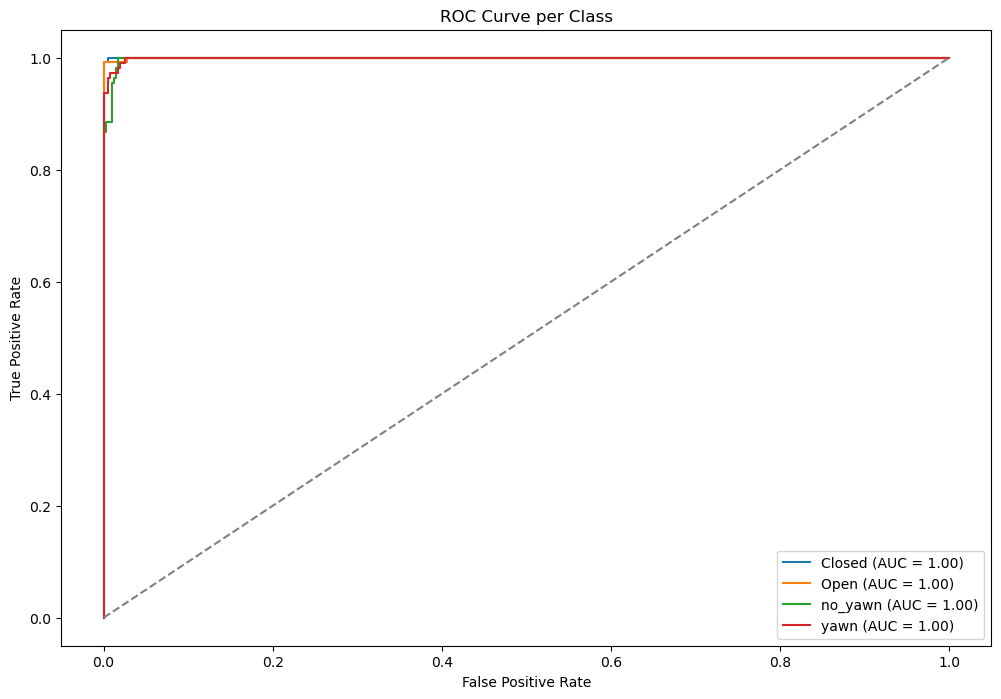

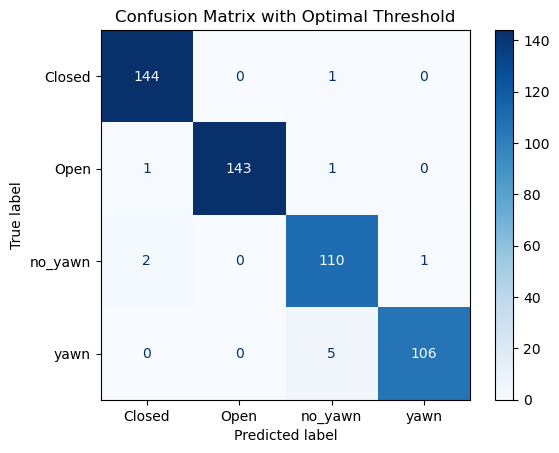


Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      Closed       0.98      0.99      0.99       145
        Open       1.00      0.99      0.99       145
     no_yawn       0.94      0.97      0.96       113
        yawn       0.99      0.95      0.97       111

    accuracy                           0.98       514
   macro avg       0.98      0.98      0.98       514
weighted avg       0.98      0.98      0.98       514



In [25]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Evaluasi dengan generator validasi
print("\n=== Evaluasi Model ===")
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# Confusion Matrix
validation_generator.reset()
y_probs = model.predict(validation_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = validation_generator.classes

# ROC Curve dan Optimal Threshold untuk setiap kelas
optimal_thresholds = []
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(train_generator.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve((y_true == i).astype(int), y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Cari threshold optimal
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    print(f"{class_name}: Optimal Threshold = {optimal_threshold:.4f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.show()

# Update Prediksi Menggunakan Optimal Threshold
y_pred_optimal = np.zeros_like(y_probs)

# Terapkan threshold optimal untuk setiap kelas
for i, threshold in enumerate(optimal_thresholds):
    y_pred_optimal[:, i] = (y_probs[:, i] > threshold).astype(int)

# Pilih kelas dengan skor tertinggi setelah thresholding
y_pred_optimal_class = np.argmax(y_pred_optimal, axis=1)

# Confusion Matrix dengan threshold optimal
cm_optimal = confusion_matrix(y_true, y_pred_optimal_class)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=list(train_generator.class_indices.keys()))
disp_optimal.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Optimal Threshold")
plt.show()

# Classification Report dengan threshold optimal
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal_class, target_names=list(train_generator.class_indices.keys())))


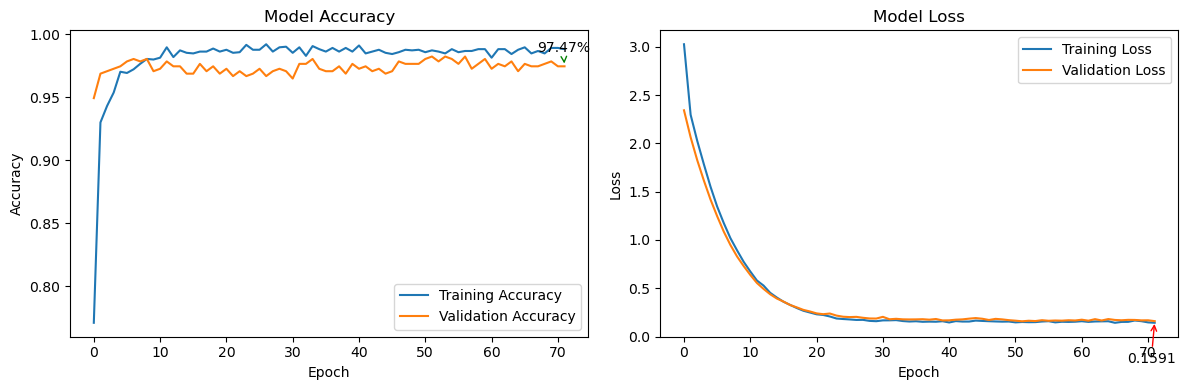

In [26]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Tambahkan anotasi akurasi validasi terakhir
final_val_accuracy = history.history['val_accuracy'][-1]
plt.annotate(f'{final_val_accuracy * 100:.2f}%', 
             xy=(len(history.history['val_accuracy']) - 1, final_val_accuracy), 
             xytext=(-20, 10), textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='green'))

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tambahkan anotasi loss validasi terakhir
final_val_loss = history.history['val_loss'][-1]
plt.annotate(f'{final_val_loss:.4f}', 
             xy=(len(history.history['val_loss']) - 1, final_val_loss), 
             xytext=(-20, -30), textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='red'))

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
model.save('mobilenet_4class.h5')
print("Model telah disimpan dalam format .h5")

Model telah disimpan dalam format .h5


In [10]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib

# Load model
model_path = "mobilenet_4class.h5"
try:
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    exit()

# Load predictor untuk landmark wajah
predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    print(f"File landmark predictor tidak ditemukan: {predictor_path}")
    exit()

predictor = dlib.shape_predictor(predictor_path)

# Fungsi untuk memproses mata dan mulut
def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None

    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_rgb, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil mata kiri dan kanan
        left_eye_points = landmarks[36:42]
        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Ekstrak bounding box untuk mata dan mulut
        def crop_roi(points):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_rgb[y_min:y_max, x_min:x_max]
            return cv2.resize(roi, (224, 224), interpolation=cv2.INTER_CUBIC) / 255.0

        left_eye = crop_roi(left_eye_points)
        right_eye = crop_roi(right_eye_points)
        mouth = crop_roi(mouth_points)

        # Prediksi untuk masing-masing ROI
        left_eye_pred = model.predict(np.expand_dims(left_eye, axis=0))[0]
        right_eye_pred = model.predict(np.expand_dims(right_eye, axis=0))[0]
        mouth_pred = model.predict(np.expand_dims(mouth, axis=0))[0]

        return {
            "left_eye_pred": left_eye_pred,
            "right_eye_pred": right_eye_pred,
            "mouth_pred": mouth_pred,
        }

# Daftar gambar untuk prediksi
image_paths = ["D:\\pcv\\test data\\menguap.jpg", "D:\\pcv\\test data\\merem.jpg"]

# Proses prediksi
for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Gambar tidak ditemukan: {image_path}")
        continue

    rois = preprocess_eye_mouth(image_path)
    if rois is not None:
        left_eye_pred = rois["left_eye_pred"]
        right_eye_pred = rois["right_eye_pred"]
        mouth_pred = rois["mouth_pred"]

        # Asumsikan urutan kelas: 
        # left_eye/right_eye: [closed, open]
        # mouth: [no_yawn, yawn]

        # Mengantuk: closed (mata) + (yawn atau no_yawn)
        mengantuk = (left_eye_pred[0] + right_eye_pred[0]) / 2  # mata tertutup
        mengantuk *= max(mouth_pred[2], mouth_pred[3])  # dikali dengan probabilitas mouth (no_yawn atau yawn)

        # Menguap: open (mata) + yawn (mulut)
        menguap = (left_eye_pred[1] + right_eye_pred[1]) / 2  # mata terbuka
        menguap *= mouth_pred[3]  # dikali dengan probabilitas yawn

        # Tidak Mengantuk: open (mata) + no_yawn (mulut)
        tidak_mengantuk = (left_eye_pred[1] + right_eye_pred[1]) / 2  # mata terbuka
        tidak_mengantuk *= mouth_pred[2]  # dikali dengan probabilitas no_yawn

        # Tentukan label dan confidence berdasarkan threshold
        label = "Tidak Terdefinisi"
        confidence = 0

        if mengantuk > menguap and mengantuk > tidak_mengantuk:
            label = "Mengantuk"
            confidence = mengantuk
        elif menguap > mengantuk and menguap > tidak_mengantuk:
            label = "Menguap"
            confidence = menguap
        elif tidak_mengantuk > mengantuk and tidak_mengantuk > menguap:
            label = "Tidak Mengantuk"
            confidence = tidak_mengantuk
        # Output hasil
        print(f"Image: {image_path}")
        print(f"Predicted Label: {label} (Confidence: {confidence:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")


Model berhasil dimuat dari: mobilenet_4class.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Image: D:\pcv\test data\menguap.jpg
Predicted Label: Mengantuk (Confidence: 0.08)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Image: D:\pcv\test data\merem.jpg
Predicted Label: Mengantuk (Confidence: 0.47)



In [20]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib
from tensorflow.keras.preprocessing import image

# Fungsi untuk memproses gambar
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambah dimensi batch (1,)
    img_array = img_array / 255.0  # Normalisasi pixel (0-1)
    return img_array

# Load predictor untuk landmark wajah
predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    print(f"File landmark predictor tidak ditemukan: {predictor_path}")
    exit()

predictor = dlib.shape_predictor(predictor_path)

# Fungsi untuk memproses mata dan mulut
def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None

    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_rgb, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil mata kiri dan kanan
        left_eye_points = landmarks[36:42]
        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Ekstrak bounding box untuk mata dan mulut
        def crop_roi(points):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_rgb[y_min:y_max, x_min:x_max]
            return cv2.resize(roi, (224, 224), interpolation=cv2.INTER_CUBIC) / 255.0

        left_eye = crop_roi(left_eye_points)
        right_eye = crop_roi(right_eye_points)
        mouth = crop_roi(mouth_points)

        return left_eye, right_eye, mouth

# Fungsi untuk memprediksi kondisi (mengantuk atau tidak)
def predict_condition(image_path, model, optimal_thresholds):
    # Preprocess image dan ekstraksi ROI
    rois = preprocess_eye_mouth(image_path)
    if rois is None:
        return None

    left_eye, right_eye, mouth = rois

    # Prediksi untuk setiap ROI
    left_eye_pred = model.predict(np.expand_dims(left_eye, axis=0))[0]
    right_eye_pred = model.predict(np.expand_dims(right_eye, axis=0))[0]
    mouth_pred = model.predict(np.expand_dims(mouth, axis=0))[0]

    # Ambil probabilitas untuk setiap kelas sesuai urutan (closed, open, no_yawn, yawn)
    left_closed_prob, left_open_prob, left_no_yawn_prob, left_yawn_prob = left_eye_pred
    right_closed_prob, right_open_prob, right_no_yawn_prob, right_yawn_prob = right_eye_pred
    mouth_no_yawn_prob, mouth_yawn_prob = mouth_pred[2], mouth_pred[3]

    # Hitung confidence scores
    confidence_scores = {
        'Mengantuk': (left_closed_prob + right_closed_prob) / 2 + max(left_no_yawn_prob, left_yawn_prob, right_no_yawn_prob, right_yawn_prob),
        'Menguap': ((left_open_prob + right_open_prob) / 2) * mouth_yawn_prob,
        'Tidak Mengantuk': ((left_open_prob + right_open_prob) / 2) * mouth_no_yawn_prob
    }

    # Normalisasi confidence scores
    total = sum(confidence_scores.values())
    confidence_scores = {k: v/total for k, v in confidence_scores.items()}

    # Tentukan label prediksi berdasarkan Confidence Score tertinggi
    predicted_label = max(confidence_scores, key=confidence_scores.get)

    # Cek jika confidence lebih rendah dari threshold untuk "Tidak Diketahui"
    if confidence_scores[predicted_label] < optimal_thresholds.get(predicted_label, 0.5):
        predicted_label = "Tidak Diketahui"

    # Return hasil
    return {
        "Image": image_path,
        "Left Eye Pred": left_eye_pred,
        "Right Eye Pred": right_eye_pred,
        "Mouth Pred": mouth_pred,
        "Confidence Scores": confidence_scores,
        "Predicted Label": predicted_label,
        "Confidence": max(confidence_scores.values())
    }

# Tentukan ambang batas untuk setiap kondisi
optimal_thresholds = {
    'Mengantuk': 0.3,    # Turunkan threshold untuk mengantuk
    'Menguap': 0.2,      # Turunkan threshold untuk menguap
    'Tidak Mengantuk': 0.3  # Sesuaikan threshold untuk tidak mengantuk
}

# Muat model yang sudah dilatih
model = load_model('mobilenet_4class.h5')

# Daftar gambar uji
test_images = [
    'D:/pcv/test data/menguap.jpg',
    'D:/pcv/test data/merem.jpg',
    'D:/pcv/test data/tdk_mengantuk1.jpg'
]

# Prediksi setiap gambar dan tampilkan hasilnya
for image_path in test_images:
    result = predict_condition(image_path, model, optimal_thresholds)
    
    if result:
        print(f"Image: {result['Image']}")
        print(f"Left Eye Prediction: {result['Left Eye Pred']}")
        print(f"Right Eye Prediction: {result['Right Eye Pred']}")
        print(f"Mouth Prediction: {result['Mouth Pred']}")
        print(f"Confidence Scores: {result['Confidence Scores']}")
        print(f"Predicted Label: {result['Predicted Label']} (Confidence: {result['Confidence']:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Image: D:/pcv/test data/menguap.jpg
Left Eye Prediction: [0.06142717 0.02189542 0.6295334  0.28714404]
Right Eye Prediction: [0.09794107 0.02480146 0.8270742  0.05018325]
Mouth Prediction: [2.9366119e-02 1.1024083e-02 7.0400879e-04 9.5890576e-01]
Confidence Scores: {'Mengantuk': 0.975886499353203, 'Menguap': 0.02409581000092764, 'Tidak Mengantuk': 1.7690645869309744e-05}
Predicted Label: Mengantuk (Confidence: 0.98)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Image: D:/pcv/test data/merem.jpg
Left Eye Prediction: [0.65633607 0.05888966 0.19545792 0.08931635]
Right Eye Prediction: [0.58287615 0.06831137 0.22452734 0.12428512]
Mouth Prediction: [0.09974352 0.01599842 0.76187617 0.12238192]
Confidence Scores: {'Mengantuk': 0.9375377899798285, 'Menguap': 0.008644812200618525, 'Tidak Mengantuk': 0.05381739781

In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib
from tensorflow.keras.preprocessing import image

# Fungsi untuk memproses gambar dan mengekstrak mata kiri, mata kanan, dan mulut
def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None

    # Load predictor untuk landmark wajah
    predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
    if not os.path.exists(predictor_path):
        print(f"File landmark predictor tidak ditemukan: {predictor_path}")
        return None

    predictor = dlib.shape_predictor(predictor_path)

    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_rgb, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil titik-titik mata kiri, mata kanan, dan mulut
        left_eye_points = landmarks[36:42]
        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Fungsi untuk crop ROI dan resize ke ukuran yang sesuai untuk model
        def crop_roi(points):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_rgb[y_min:y_max, x_min:x_max]
            return cv2.resize(roi, (224, 224), interpolation=cv2.INTER_CUBIC) / 255.0

        left_eye = crop_roi(left_eye_points)
        right_eye = crop_roi(right_eye_points)
        mouth = crop_roi(mouth_points)

        return left_eye, right_eye, mouth

# Fungsi untuk memprediksi kondisi (mengantuk atau tidak)
def predict_condition(image_path, model, optimal_thresholds):
    # Preprocess image dan ekstraksi ROI
    rois = preprocess_eye_mouth(image_path)
    if rois is None:
        return None

    left_eye, right_eye, mouth = rois

    # Prediksi untuk setiap ROI
    left_eye_pred = model.predict(np.expand_dims(left_eye, axis=0))[0]
    right_eye_pred = model.predict(np.expand_dims(right_eye, axis=0))[0]
    mouth_pred = model.predict(np.expand_dims(mouth, axis=0))[0]

    # Ambil probabilitas untuk setiap kelas sesuai urutan (closed, open, no_yawn, yawn)
    left_closed_prob, left_open_prob, left_no_yawn_prob, left_yawn_prob = left_eye_pred
    right_closed_prob, right_open_prob, right_no_yawn_prob, right_yawn_prob = right_eye_pred
    mouth_no_yawn_prob, mouth_yawn_prob = mouth_pred[2], mouth_pred[3]

    # Hitung confidence scores
    confidence_scores = {
        'Mengantuk': (left_closed_prob + right_closed_prob) / 2 + max(left_no_yawn_prob, left_yawn_prob, right_no_yawn_prob, right_yawn_prob),
        'Menguap': ((left_open_prob + right_open_prob) / 2) * mouth_yawn_prob,
        'Tidak Mengantuk': ((left_open_prob + right_open_prob) / 2) * mouth_no_yawn_prob
    }

    # Normalisasi confidence scores
    total = sum(confidence_scores.values())
    confidence_scores = {k: v / total for k, v in confidence_scores.items()}

    # Tentukan label prediksi berdasarkan Confidence Score tertinggi
    predicted_label = max(confidence_scores, key=confidence_scores.get)

    # Cek jika confidence lebih rendah dari threshold untuk "Tidak Diketahui"
    if confidence_scores[predicted_label] < optimal_thresholds.get(predicted_label, 0.5):
        predicted_label = "Tidak Diketahui"

    # Return hasil
    return {
        "Image": image_path,
        "Left Eye Pred": left_eye_pred,
        "Right Eye Pred": right_eye_pred,
        "Mouth Pred": mouth_pred,
        "Confidence Scores": confidence_scores,
        "Predicted Label": predicted_label,
        "Confidence": max(confidence_scores.values())
    }

# Tentukan ambang batas untuk setiap kondisi
optimal_thresholds = {
    'Mengantuk': 0.3,    # Turunkan threshold untuk mengantuk
    'Menguap': 0.2,      # Turunkan threshold untuk menguap
    'Tidak Mengantuk': 0.3  # Sesuaikan threshold untuk tidak mengantuk
}

# Muat model yang sudah dilatih
model = load_model('mobilenet_4class.h5')

# Daftar gambar uji
test_images = [
    'D:/pcv/test data/menguap.jpg',
    'D:/pcv/test data/merem.jpg',
    'D:/pcv/test data/tdk_mengantuk1.jpg'
]

# Prediksi setiap gambar dan tampilkan hasilnya
for image_path in test_images:
    result = predict_condition(image_path, model, optimal_thresholds)
    
    if result:
        print(f"Image: {result['Image']}")
        print(f"Left Eye Prediction: {result['Left Eye Pred']}")
        print(f"Right Eye Prediction: {result['Right Eye Pred']}")
        print(f"Mouth Prediction: {result['Mouth Pred']}")
        print(f"Confidence Scores: {result['Confidence Scores']}")
        print(f"Predicted Label: {result['Predicted Label']} (Confidence: {result['Confidence']:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Image: D:/pcv/test data/menguap.jpg
Left Eye Prediction: [0.06142717 0.02189542 0.6295334  0.28714404]
Right Eye Prediction: [0.09794107 0.02480146 0.8270742  0.05018325]
Mouth Prediction: [2.9366119e-02 1.1024083e-02 7.0400879e-04 9.5890576e-01]
Confidence Scores: {'Mengantuk': 0.975886499353203, 'Menguap': 0.02409581000092764, 'Tidak Mengantuk': 1.7690645869309744e-05}
Predicted Label: Mengantuk (Confidence: 0.98)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Image: D:/pcv/test data/merem.jpg
Left Eye Prediction: [0.65633607 0.05888966 0.19545792 0.08931635]
Right Eye Prediction: [0.58287615 0.06831137 0.22452734 0.12428512]
Mouth Prediction: [0.09974352 0.01599842 0.76187617 0.12238192]
Confidence Scores: {'Mengantuk': 0.9375377899798285, 'Menguap': 0.008644812200618525, 'Tidak Mengantuk': 0.053817397